# Teleportacion

In [1]:
import qiskit
import numpy as np

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

Creamos el circuito quantico

In [3]:
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

In [4]:
# Hacemos el estado de Bell
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [5]:
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

In [6]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

En quiskit necesitamos separar los registros clasicos para almacenar los resultados de la medicion.

In [7]:
# Enviamos el qubit de Alice 
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

In [8]:
#Medimos los dos qubits de Alice y almacenamos el resultado en el los bits clasicos
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [9]:
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

In [10]:
# Bob ya tiene el qubit, tenemos que aplicar las operaciones correspodientes segun los bits recibidos
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

In [11]:
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ 
                                  ║  ║       │   ┌──┴──┐
crz: 1/═══════════════════════════╩══╬═══════╪═══╡ = 1 ╞
                                  0  ║    ┌──┴──┐└─────┘
crx: 1/══════════════════════════════╩════╡ = 1 ╞═══════
                                     0    └─────┘

# Simulacion

<IPython.core.display.Math object>

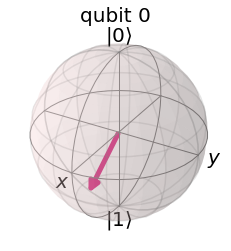

In [12]:
#Creamos un qubit aleatorio para teletransportar
psi = random_state(1)

# Display it nicely
array_to_latex(psi, pretext="|\\psi\\rangle =")
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

In [13]:
init_gate = Initialize(psi)
init_gate.label = "init"

# Simulador Statevector

In [14]:
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ 
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─
                ░      └───┘ ░            ░  ║  ║  └─┬─┘  └─┬─┘ 
                                             ║  ║    │   ┌──┴──┐
crz: 1/══════════════════════════════════════╩══╬════╪═══╡ = 1 ╞
                                             0  ║ ┌──┴──┐└─────┘
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞═══════
                                                0 └─────┘

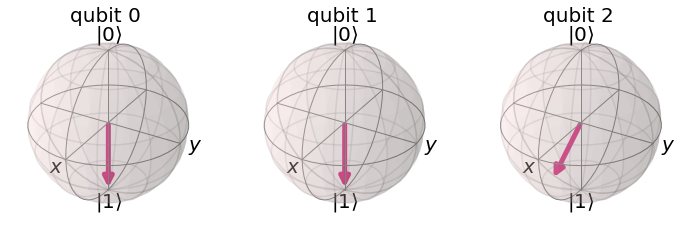

In [15]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
out_vector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(out_vector)

Aqui podemos ver como el qubit 0 y el 1 han perdido su estado y se han colapsado, mientras el qubit 2 es el que ha obtenido el estado, tal como hemos visto en el ejercicio 1.

# Teleportacion Cuantica en un Backend real

Los computadores cuantico actuales de IBM no son capaces realizar mas operaciones despues de hacer sus mediciones. Para ello necesitamos hacer ciertos cambios para mover todas las mediciones hasta el final.

In [16]:
def new_bob_gates(teleportation, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

In [17]:
inverse_init_gate = init_gate.gates_to_uncompute()

In [18]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░                            
q_0: ┤ init ├─░────────────░───■──┤ H ├─░───────■────────────────────
     └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░       │                    
q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░───■───┼────────────────────
              ░ └───┘┌─┴─┐ ░ └───┘      ░ ┌─┴─┐ │ ┌──────────────┐┌─┐
q_2: ─────────░──────┤ X ├─░────────────░─┤ X ├─■─┤ disentangler ├┤M├
              ░      └───┘ ░            ░ └───┘   └──────────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════╩═
                                                                   0

In [19]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

/home/feynman/anaconda3/envs/qiskitEnv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [20]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)
job_monitor(job)  # displays job status under cell

Job Status: job has successfully run


{'0': 907, '1': 117}


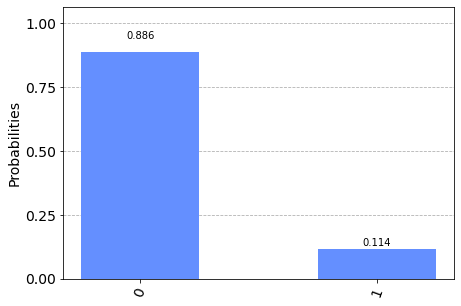

In [21]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

In [22]:
print(f"The experimental error rate : {exp_counts['1']/sum(exp_counts.values()):.3f}%")

The experimental error rate : 0.114%


Al realizar la teleportacion cuantica en los ordenadores cuanticos reales, observamos que puede haber un error de 1.14%, debido al ruido.

# Codificacion superdensa

In [23]:
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

In [24]:
def create_bell_pair(qc, a, b):
    qc.h(a) # Apply a h-gate to the first qubit
    qc.cx(a,b) # Apply a CNOT, using the first qubit as the control

In [25]:
def encode_message(qc, qubit, msg):
    if msg == "00":
        pass    # To send 00 we do nothing
    elif msg == "10":
        qc.x(qubit) # To send 10 we apply an X-gate
    elif msg == "01":
        qc.z(qubit) # To send 01 we apply a Z-gate
    elif msg == "11":
        qc.z(qubit) # To send 11, we apply a Z-gate
        qc.x(qubit) # followed by an X-gate
    else:
        print("Invalid Message: Sending '00'")

In [26]:
def decode_message(qc, a, b):
    qc.cx(a,b)
    qc.h(a)

In [27]:
# Create the quantum circuit with 2 qubits
qc = QuantumCircuit(2)

# First, Charlie creates the entangled pair between Alice and Bob
create_bell_pair(qc, 0, 1)
qc.barrier() # This adds a barrier to our circuit. A barrier 
             # separates the gates in our diagram and makes it 
             # clear which part of the circuit is which

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 0. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = "10"
encode_message(qc, 0, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After recieving qubit 0, Bob applies the recovery protocol:
decode_message(qc, 0, 1)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw()

┌───┐      ░ ┌───┐ ░      ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤ X ├─░───■──┤ H ├─░─┤M├───
        └───┘┌─┴─┐ ░ └───┘ ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░───────░─┤ X ├──────░──╫─┤M├
             └───┘ ░       ░ └───┘      ░  ║ └╥┘
meas: 2/═══════════════════════════════════╩══╩═
                                           0  1

{'10': 1024}


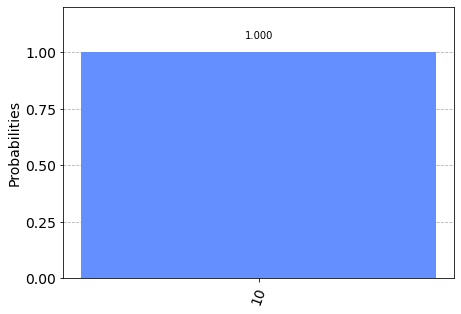

In [28]:
qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(qc)
result = qasm_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

Como podemos ver, el simulador funciona perfectamente, tenemos un 100% de posibilidad de medir el mensaje correcto  

# Codificacion superdensa en un Backend real

In [29]:
# from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 1024

# Load local account information
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)

/home/feynman/anaconda3/envs/qiskitEnv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-03-28 22:46:35,537: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_quito


In [30]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


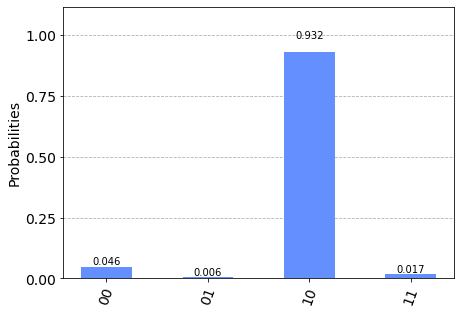

In [31]:
result = job.result()
plot_histogram(result.get_counts(qc))

Como podemos ver, debido al ruido,obtenemos algunos resultados no deseados. Pero aun asi, la probabilidad de obtener el resultado correcto, es mucho mayor que los demas.